In [11]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import seaborn as sns

import pandas as pd

import os

import sys
sys.path.insert(0, "../helper")
print(sys.path)

# own module
from visualisation.colour import *


['../helper', 'C:\\Users\\Prinzessin\\projects\\decentnet\\datasceyence\\plotting', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\python39.zip', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\DLLs', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta', '', 'C:\\Users\\Prinzessin\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Prinzessin\\.ipython']


In [34]:
path = r"C:/Users/Prinzessin/projects/decentnet/datasceyence/examples/example_results/lightning_logs/debug_octmnist_no_fc/version_14"

# data = pd.read_csv(os.path.join(path, "out_final_test.csv"))

map_path = r'C:/Users/Prinzessin/projects/decentnet/datasceyence/examples/example_results/lightning_logs/debug_octmnist_no_fc/version_14'

# C:/Users/Prinzessin/projects/decentnet/datasceyence/examples/example_results/lightning_logs/dumpster/version_24

tmp_path = os.path.join(path, "radar")
os.makedirs(tmp_path, exist_ok=True)

colours = normal_amd_cnv_dr.colors
colours

[(0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725)]

In [35]:
def plot_all_filters(data, theta): # only works for 4 ...
    
    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                        subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
    
    # Plot the n filters
    for ax, (title, filter_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(filter_data, colours):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.5, label='_nolegend_')
        ax.set_varlabels(concept_labels)

    # add legend relative to top-left plot
    legend = axs[0, 0].legend(disease_labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Filter-wise disease-concept matching', # (cluster afterwards!!!)
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.savefig(os.path.join(tmp_path, "radar.png"), bbox_inches='tight')    
    
def plot_each_filter(data, theta, make_pretty=False):
    
    # Plot the n filters
    for title, filter_data in data:
        
        try:
            fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
            fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
        
        
            if make_pretty:
                ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                             horizontalalignment='center', verticalalignment='center')
            for d, color in zip(filter_data, colours):
                ax.plot(theta, d, color=color, linewidth=4)
                ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
            ax.set_varlabels(concept_labels)

            if make_pretty:
                # add legend relative to top-left plot
                _ = ax.legend(disease_labels, loc=(0.9, .95),
                                          labelspacing=0.1, fontsize='small')

            plt.savefig(os.path.join(tmp_path, f'''radar_{title}.png'''), bbox_inches='tight')    
            plt.close()    
        except Exception as E:
            print("not enough data")
            print(E)

In [45]:


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

import glob

def get_csv_data():
    
    # this is actually median
    med_and_std_paths = glob.glob(os.path.join(path,"final_plots/mean_and_std_*.csv"))

    

    df = pd.read_csv(med_and_std_paths[0])

    #disease_labels = ('AMD', 'nvAMD', 'DR', 'normal')
    disease_labels = df['Disease label'].unique()
    area_labels = df['area'].unique()

    data = [list(area_labels)]

    for p in med_and_std_paths:
        # the rows are the diseases, the columns are the areas

        filter_id = p.split("std_")[1].split(".")[0]
        
        df = pd.read_csv(p)


        #df[df['disease'] == 'A']['texture'].reset_index(drop=True)

        list_list = []
        for disease in disease_labels:
            list_list.append(list(df[df['Disease label'] == disease]['median']))

        #print()
        #list_list = list(df["median"])


        data.append((filter_id, list_list)) # list_list

    return data, disease_labels
        
    

def example_data():
    
    # filter wise data can also be clustered afterwards
    # 'others', 'normal', 'AMD', 'DR', 'CSC', 'nvAMD', 'RVO'
    disease_labels = ('AMD', 'nvAMD', 'DR', 'normal') # , 'CSC', 'RVO')
    
    data = [
        ["something", "drusen", "intra-fluid", "sub-fluid", "neovasc", "hyperref", "anorysm", "this", "that"],
        ('0_2_3', [ # 5 diseases, n concepts
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00], 
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            #[0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]
        ]),
        ('0_7_3', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            #[0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]
        ]),
        ('14_13_3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            #[0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]
        ]),
        ('2_1_1', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.50, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            #[0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]
        ])
    ]
    
    return data, disease_labels





In [46]:
a, b = example_data()
a

[['something',
  'drusen',
  'intra-fluid',
  'sub-fluid',
  'neovasc',
  'hyperref',
  'anorysm',
  'this',
  'that'],
 ('0_2_3',
  [[0.88, 0.01, 0.03, 0.03, 0.0, 0.06, 0.01, 0.0, 0.0],
   [0.07, 0.95, 0.04, 0.05, 0.0, 0.02, 0.01, 0.0, 0.0],
   [0.01, 0.02, 0.85, 0.19, 0.05, 0.1, 0.0, 0.0, 0.0],
   [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.0, 0.0]]),
 ('0_7_3',
  [[0.88, 0.02, 0.02, 0.02, 0.0, 0.05, 0.0, 0.05, 0.0],
   [0.08, 0.94, 0.04, 0.02, 0.0, 0.01, 0.12, 0.04, 0.0],
   [0.01, 0.01, 0.79, 0.1, 0.0, 0.05, 0.0, 0.31, 0.0],
   [0.0, 0.02, 0.03, 0.38, 0.31, 0.31, 0.0, 0.59, 0.0]]),
 ('14_13_3',
  [[0.89, 0.01, 0.07, 0.0, 0.0, 0.05, 0.0, 0.0, 0.03],
   [0.07, 0.95, 0.05, 0.04, 0.0, 0.02, 0.12, 0.0, 0.0],
   [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.0, 0.0, 0.0],
   [0.01, 0.03, 0.0, 0.32, 0.29, 0.27, 0.0, 0.0, 0.95]]),
 ('2_1_1',
  [[0.87, 0.01, 0.08, 0.0, 0.0, 0.04, 0.0, 0.0, 0.01],
   [0.09, 0.95, 0.02, 0.03, 0.5, 0.01, 0.13, 0.06, 0.0],
   [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.0, 

In [47]:
#get_csv_data()

In [48]:
data, disease_labels = get_csv_data()
# data

In [49]:
data, disease_labels = example_data()
len(data[0])

9

not enough data
x and y must have same first dimension, but have shapes (7,) and (0,)
not enough data
x and y must have same first dimension, but have shapes (7,) and (0,)
not enough data
x and y must have same first dimension, but have shapes (7,) and (0,)


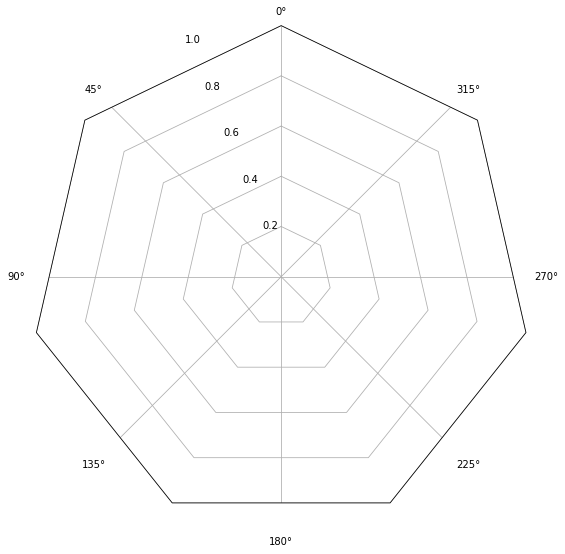

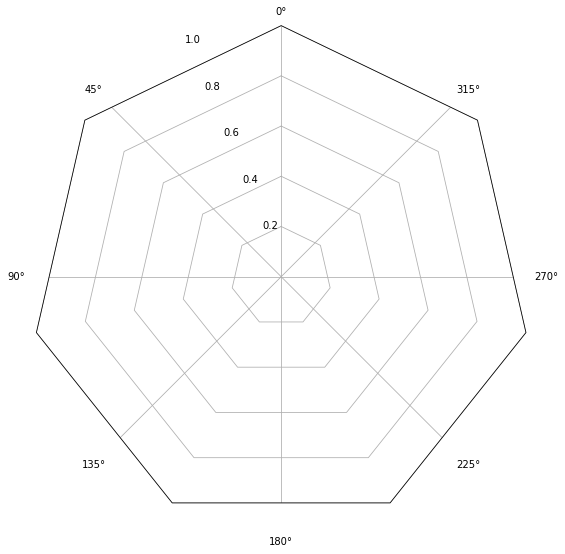

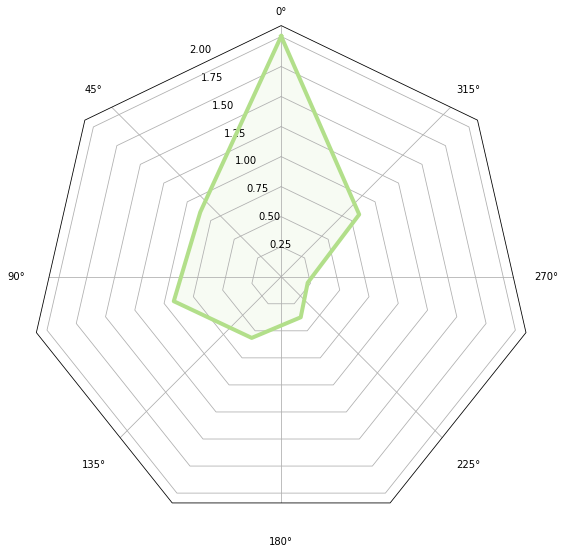

In [50]:
# colors = ['#4682B4', '#DC143C', '#FF8C00', '#00CED1', '#9400D3']
#colors = ['#AEC6CF', '#FFB6C1', '#FFDAB9', '#B39EB5', '#FF6961']
#colors = ['#87A7B3', '#FF9AA2', '#FFB69E', '#937D92', '#E25B5D']
#colors = ['#55787F', '#FF5A66', '#FF7C5F', '#6D5671', '#C43E41']

# colors = ['#FF0000', '#00FFFF', '#FF5700', '#370617', '#FF006E']

#colors = sns.color_palette("Paired")[4:]
# diverging
#colors = sns.color_palette("Paired")
#colors.pop(4)
#colors.pop(4)

#colors = sns.color_palette("diverging")

#colors = ['#8A2BE2', '#00CED1', '#FF7F50', '#00FF00']
#colors = ['#8A2BE2', '#00CED1', '#FF7F50', '#FFD700']

data, disease_labels = get_csv_data()
concept_labels = data[0]


data = data[1:]

N = len(concept_labels)
theta = radar_factory(N, frame='polygon')



plot_each_filter(data, theta, make_pretty=False)

    



In [44]:
# data